In [1]:
#!/usr/bin/python

import sys
import pickle
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [2]:
### Load the dictionary containing the dataset
# pickle compatible with python3
with open("final_project_dataset_python3.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## Explorando os dados

### Análise das Características e Remoção de Outliers

Para manter os dados ainda compatíveis com o `tester.py` na análise será
realizado sobre um dataframe, porém posteriormente será aplicado os ajustes
no dicionário.

In [3]:
data_df = pd.DataFrame.from_dict(data_dict).T
print(data_df.dtypes.value_counts())

object    21
dtype: int64


Todos os campos são importados como strings, assim para uma avaliação dos
outliers primeiro temos que converter os campos para numéricos.

In [4]:
# seleciona as colunas que não são numéricas
cols_string = ['email_address', 'poi']
cols = list(data_df)

# seleciona as variáveis numéricas
cols_numeric = np.setdiff1d(cols, cols_string)

# transforma os valores em números e quando 'NaN' em NaN
data_df[cols_numeric] = data_df[cols_numeric].apply(pd.to_numeric, errors='coerce')
data_df['poi'] = data_df['poi'].astype('bool')

# sumário dos dados transposto para melhor visualização
print(data_df.describe().T[['count', 'min', 'mean', 'max']])

                           count         min          mean          max
bonus                       82.0     70000.0  2.374235e+06   97343619.0
deferral_payments           39.0   -102500.0  1.642674e+06   32083396.0
deferred_income             49.0 -27992891.0 -1.140475e+06       -833.0
director_fees               17.0      3285.0  1.668049e+05    1398517.0
exercised_stock_options    102.0      3285.0  5.987054e+06  311764000.0
expenses                    95.0       148.0  1.087289e+05    5235198.0
from_messages               86.0        12.0  6.087907e+02      14368.0
from_poi_to_this_person     86.0         0.0  6.489535e+01        528.0
from_this_person_to_poi     86.0         0.0  4.123256e+01        609.0
loan_advances                4.0    400000.0  4.196250e+07   83925000.0
long_term_incentive         66.0     69223.0  1.470361e+06   48521928.0
other                       93.0         2.0  9.190650e+05   42667589.0
restricted_stock           110.0  -2604490.0  2.321741e+06  1303

Pode ser notado que algumas das variáveis não podemos utilizar pela grande
quantidade de informação faltando. Isso ocorre principalmente para as
variáveis `director_fees`, `loan_advances` e `restricted_stock_deferred`.

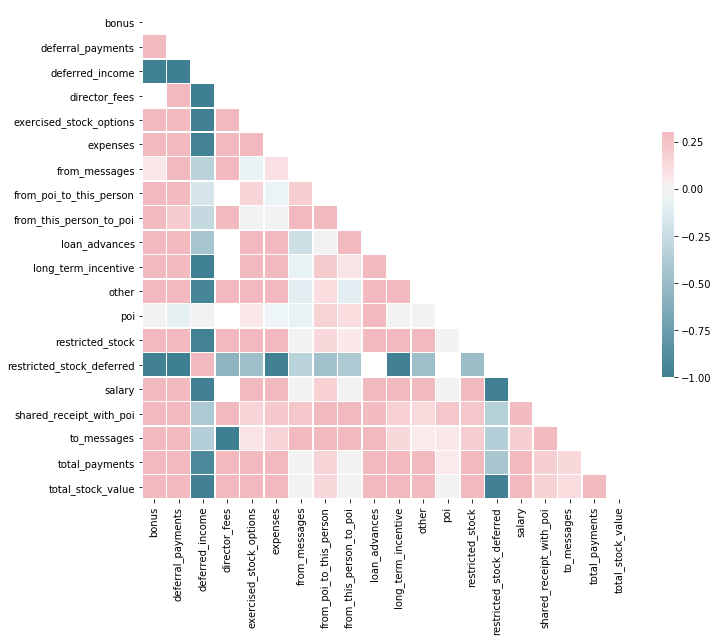

In [5]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = data_df.corr()

# cria uma máscara para o triangulo superior
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# configura o plt
f, ax = plt.subplots(figsize=(11, 9))

# cria as cores para as relações
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# desenha o gráfico com a relação de cores associadas com a correlação
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
def tag_outlier(df, columns):
    """ Identifica possíveis outliers, colocado um range maior
        para um outlier visto que os dados possuem uma grande 
        variância, e a identificação de poi está associada a 
        valores extremos.
    Args:
        variable: pandas dataframe
    Returns:
        row index
    Raises:
    """
    def column_outlier_eval(variable):
        q1, q3 = variable.quantile([.25, .75])
        inter_q = q3 - q1
        max_val = q3 + 5 * inter_q
        min_val = q1 - 5 * inter_q
        return variable[(variable > max_val) | (variable < min_val)].index

    rows_to_look = []
    for var in columns:
        rows_to_look.append(list(column_outlier_eval(df[var])))

    possible_outlier = np.unique([j for i in rows_to_look for j in i])
    return possible_outlier

def too_many_nan(df, qty_limit):
    """ Identifica as linhas com muitos NaN
    Args:
        variable: pandas dataframe
    Returns:
        row index
    Raises:
    """
    qty_nan = df.isnull().sum(axis=1)
    print(qty_nan.loc[qty_nan > qty_limit].sort_values())
    

In [7]:
tag_outlier(data_df, cols_numeric)
too_many_nan(data_df, 16)

GRAMM WENDY L                    17
SCRIMSHAW MATTHEW                17
THE TRAVEL AGENCY IN THE PARK    17
WHALEY DAVID A                   17
WODRASKA JOHN                    17
WROBEL BRUCE                     17
LOCKHART EUGENE E                19
dtype: int64


In [8]:
print(data_df.loc['LOCKHART EUGENE E'])

bonus                          NaN
deferral_payments              NaN
deferred_income                NaN
director_fees                  NaN
email_address                  NaN
exercised_stock_options        NaN
expenses                       NaN
from_messages                  NaN
from_poi_to_this_person        NaN
from_this_person_to_poi        NaN
loan_advances                  NaN
long_term_incentive            NaN
other                          NaN
poi                          False
restricted_stock               NaN
restricted_stock_deferred      NaN
salary                         NaN
shared_receipt_with_poi        NaN
to_messages                    NaN
total_payments                 NaN
total_stock_value              NaN
Name: LOCKHART EUGENE E, dtype: object


Observando os dados podemos observar o aparecimento de uma pessoa chamada
`TOTAL` o que nos aponta para um provável erro de digitação que podemos
eliminar dos dados.

Outro ponto é o aparecimento de uma agencia de viagens nos dados
`THE TRAVEL AGENCY IN THE PARK` que ao não representar uma pessoa será removido.

Por último temos uma pessoa chamada `LOCKHART EUGENE E` que não possuímos
nenhuma informação referente, assim também será removido.

In [9]:
items_to_drop = ['TOTAL','THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
for outlier in items_to_drop:
    data_dict.pop(outlier, 0)
    
data_df.drop(items_to_drop, inplace=True)

### Criação de Novas Variáveis

Para a criação de novas variáveis será utilizado a relação entre a quantidade
de emails enviadas para `poi` e a quantidade total de emails enviada por cada
pessoa.

In [26]:
if_nan_make_zero = lambda x : 0 if x == 'NaN' else x 

for poi in data_dict:
    if data_dict[poi]['to_messages'] == 'NaN':
        data_dict[poi]['msg_to_poi_prec'] = 0
    else:
        data_dict[poi]['msg_to_poi_prec'] = if_nan_make_zero(data_dict[poi]['from_this_person_to_poi']) / \
                                if_nan_make_zero(data_dict[poi]['to_messages'])

data_df['msg_to_poi_prec'] = data_df['from_this_person_to_poi'] / data_df['to_messages']

### Avaliação das Variáveis


Primeiro vamos avaliar as variáveis disponíveis pelo score relativo ao `poi`. 
Isso é feito utilizando o `SelectBest` e observando o score obtido pelo `fit`
do modelo.

In [27]:
# seleciona as colunas que não são numéricas
cols_remove = ['email_address', 'poi']
cols = list(data_df)

# de todas as colunas, selecionamos as que são numéricas
cols_features = np.setdiff1d(cols, cols_remove)

features = data_df.loc[:, cols_features]
features.fillna(0, inplace=True)

labels = data_df.loc[:, 'poi']

from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=2)
selector.fit(features, labels)

SelectKBest(k=2, score_func=<function f_classif at 0x00000193162CE0D0>)

In [28]:
features_scores = pd.Series(list(features))
features_scores = pd.concat([features_scores.reset_index(drop=True), 
                             pd.Series(selector.scores_)], axis=1)
features_scores.columns = ['variable', 'score']
features_scores.set_index('variable', inplace=True)
print(features_scores.sort_values(by=['score'], ascending=False))

                               score
variable                            
exercised_stock_options    24.815080
total_stock_value          24.182899
bonus                      20.792252
salary                     18.289684
deferred_income            11.458477
long_term_incentive         9.922186
restricted_stock            9.212811
total_payments              8.772778
shared_receipt_with_poi     8.589421
loan_advances               7.184056
expenses                    6.094173
from_poi_to_this_person     5.243450
other                       4.187478
msg_to_poi_prec             4.094653
from_this_person_to_poi     2.382612
director_fees               2.126328
to_messages                 1.646341
deferral_payments           0.224611
from_messages               0.169701
restricted_stock_deferred   0.065500


Ao observar os scores, podemos observar que 4 dos mesmos possuem notas
razoáveis acima de 10, sendo as variáveis que serão utilizadas para o 
modelo.

Outro método que será avaliado é a utilização do PCA para a redução de
dimensões dos nossos dados. Para entender a quantidade de dimensões que
devemos escolher, podemos observar a variância das dimensões. A variância
está relacionada a quantidade de informação que cada componente do PCA
agrega ao modelo.

A variável criada anteriormente acaba não retornando uma boa classificação,
assim como todas as variáveis relacionadas a e-mails. Dessa forma não será
utilizada nos modelos.

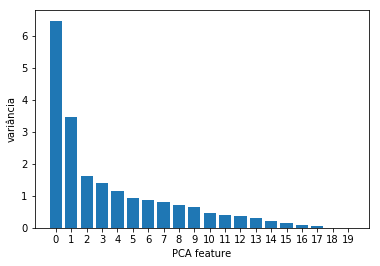

In [29]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scalar, pca)

pipeline.fit(features)

features_qty = range(pca.n_components_)
plt.bar(features_qty, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variância')
plt.xticks(features_qty)
plt.show()

Podemos assumir que com 5 componentes do PCA podemos uma quantidade de
informação para explicar os dados. A partir do quarto componente existe
uma variação muito baixa de variância indicando uma baixa agregação de
informação.

### Metrica de avaliação dos modelos

Os dados apresentam um bias muito grande na relação de poi e não poi

In [44]:
print("Quantidade de Poi: {}".format(sum(data_df['poi'])))
print("Tamanho dos dados: {}".format(data_df.shape))

Quantidade de Poi: 18
Tamanho dos dados: (143, 22)


Existem apenas 18 poi, o que acarreta que a métrica de acurácia irá
favorecer modelos com altas indicações de não poi, sendo que um modelo
que indique não poi para todos consegue ~87% acurácia.

Para evitar não favorecer um grande aparecimento de *False Negative*
(os casos de poi classificados como não poi) utilizaremos como
principal métrica o ***recall***. O recall possui sua fórmula:

*true_positives / (true_positives + false_negatives)*

Assim aumentando o denominador nos casos do aparecimento de *False
Negatives* que são os casos que não são identificados os poi.

A segunda métrica a ser avaliada é a ***precision***, visto que dado
uma classificação de um item como poi, o mesmo ser realmente poi.

### Pipelines dos modelos iniciais

Os dados apresentam grandes variações de magnitude, assim será aplicado um
escalonamento das variáveis nos pipelines para que não afete os modelos 
sensíveis a essas variações.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [15]:
def tester(clf, sss, features, labels):
    """ Realiza a avaliação do modelo de classificação igual ao
    teste fornecido em tester.py porém usando python3 e pandas
    Args:
        clf: classificador
        sss: split dos dados por StratifiedShuffleSplit
        features: pandas df com as variáveis
        labels: pandas df com o target
    Returns:
        não há retorno, apenas um print da avaliação do modelo
    Raises:
    """
        
    # formatação ajustada para 1 item por linha no local de tabs
    PERF_FORMAT_STRING = "\
        Accuracy: {:>0.{display_precision}f}\n\
        Precision: {:>0.{display_precision}f}\n\
        Recall: {:>0.{display_precision}f}\n\
        F1: {:>0.{display_precision}f}\n\
        F2: {:>0.{display_precision}f}"
    RESULTS_FORMAT_STRING = "\
        Total predictions: {:4d}\n\
        True positives: {:4d}\n\
        False positives: {:4d}\n\
        False negatives: {:4d}\n\
        True negatives: {:4d}"

    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    
    for train_index, test_index in sss.split(features, labels):
        features_train, features_test = features.iloc[train_index], features.iloc[test_index]
        labels_train, labels_test = labels.iloc[train_index], labels.iloc[test_index]

        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)
    
        for prediction, truth in zip(pred, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
    
    print(clf)
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print(PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5))
        print(RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, 
                                           false_negatives, true_negatives))
        print("")
    except:
        # no caso de ocorrer divisão por zero nos indicadores, retorna apenas os
        # valores da conf matrix
        print(RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, 
                                           false_negatives, true_negatives))
        

Vamos criar 2 grupos de variáveis. O primeiro sendo as variáveis que selecionamos
anteriormente como as mais importantes `features_select`. O segundo sendo todas as
variáveis disponíveis `features_total`, para utilização do PCA e na referência de 
como a seleção se comporta frente ao todo.

In [30]:
cols = ['exercised_stock_options', 'total_stock_value', 'bonus', 'salary']
features_select = data_df.loc[:, cols].fillna(0)

cols_remove = ['email_address', 'poi']
cols = list(data_df)
cols_features = np.setdiff1d(cols, cols_remove)
features_total = data_df.loc[:, cols_features].fillna(0)

labels_poi = data_df.loc[:, 'poi']

In [31]:
# criação do shuffle dos dados com seed fixo para replicação
sss = StratifiedShuffleSplit(n_splits = 1000, random_state = 42)

### Aplicação de Classificadores

#### Gaussian Naive Bayes 

Primeiramente vamos aplicar o GaussianNB com todas as variáveis disponíveis.

Em todos os modelos de GaussianNB será utilizado a normalização dos dados com
o `StandardScaler` pois existe uma diferença muito grande de escala entre as 
variáveis.

In [18]:
clf = make_pipeline(StandardScaler(), 
                    GaussianNB())
clf_pca = make_pipeline(StandardScaler(), 
                        PCA(n_components=4), 
                        GaussianNB())

tester(clf, sss, features_total, labels_poi)
tester(clf, sss, features_select, labels_poi)
tester(clf_pca, sss, features_total, labels_poi)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gaussiannb', GaussianNB(priors=None))])
        Accuracy: 0.37633
        Precision: 0.15473
        Recall: 0.82400
        F1: 0.26053
        F2: 0.44180
        Total predictions: 15000
        True positives: 1648
        False positives: 9003
        False negatives:  352
        True negatives: 3997

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gaussiannb', GaussianNB(priors=None))])
        Accuracy: 0.85460
        Precision: 0.44180
        Recall: 0.34350
        F1: 0.38650
        F2: 0.35950
        Total predictions: 15000
        True positives:  687
        False positives:  868
        False negatives: 1313
        True negatives: 12132

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='au

O algoritmo de Gaussian Naive Bayes apresenta resultados melhores quando utilizado
as variáveis selecionadas frente a utilização do PCA e da utilização de todas as
variáveis. Com as variáveis selecionadas podemos observar que os valores da precisão
e do recall então dentro das margens solicitadas para o projeto de 0.3 em ambos.

#### Support Vector Machine (SVM)

In [19]:
clf = make_pipeline(StandardScaler(), 
                    SVC())
clf_pca = make_pipeline(StandardScaler(), 
                        PCA(n_components=4), SVC())

tester(clf, sss, features_total, labels_poi)
tester(clf, sss, features_select, labels_poi)
tester(clf_pca, sss, features_total, labels_poi)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
        Total predictions: 15000
        True positives:    0
        False positives:    0
        False negatives: 2000
        True negatives: 13000
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
        Total predictions: 15000
        True positives:    0
        False positives:  107
        False negatives: 2000
        True negatives: 12893


O SVM com inicialmente nos retorna resultados ruins para os *True Positives*,
isso é um fator que pode ser avaliado posteriormente na melhora do modelo por
meio de ajuste dos hyper-parâmetros para aumentar a penalidade nos "erros".
Com isso pode ser melhorado as estimativas para reduzir os *False Negatives* e
melhorar o *True Positives*.

#### Decision Tree Classifier

In [20]:
clf = make_pipeline(StandardScaler(), 
                    DecisionTreeClassifier(random_state=0))
clf_pca = make_pipeline(StandardScaler(), 
                        PCA(n_components=4), 
                        DecisionTreeClassifier(random_state=0))

tester(clf, sss, features_total, labels_poi)
tester(clf, sss, features_select, labels_poi)
tester(clf_pca, sss, features_total, labels_poi)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])
        Accuracy: 0.79393
        Precision: 0.22126
        Recall: 0.21650
        F1: 0.21885
        F2: 0.21743
        Total predictions: 15000
        True positives:  433
        False positives: 1524
        False negatives: 1567
        True negatives: 11476

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=N

Por meio do Decision Tree obtemos resultados próximos aos desejados, sendo que a
utilização das variáveis selecionadas com uma pequena vantagem sobre a utilização
do PCA.

### Seleção Final das Variáveis

In [21]:
# seleção das variáveis para aplicar no tester.py
# a primeira variável necessita ser o poi
features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary']

In [22]:
# aloca em my_dataset sendo a variável esperada pelas funções
# fornecidas
my_dataset = data_dict

In [23]:
### extração dos dados utilizando funções fornecidas
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Melhora do Modelo pelos Parâmetros

Mesmo o Naive Bayes (NB) tendo os melhores resultados até o momento, iremos
tentar melhorar por meio de procura de parâmetros o SVM pois o NB não possui 
hyper-parametros para serem alterado.

In [24]:
steps = [('scaler', StandardScaler()),
         ('svc', SVC())]

pipeline = Pipeline(steps)

# seleção dos hyper-parâmetros a serem testados
# foi selecionado opcoes de alto C para contra balançar o
# baixo True Positive observado no teste inicial
parameters = {'svc__kernel': ('rbf', 'linear'),
            'svc__gamma':  ['auto', 0.6, 0.7, 0.8, 0.9, 1.0],
            'svc__C': [100.0, 1000.0, 10000.0, 20000.0],
             }

# usamos uma quantidade menor de splits devido a quantidade resultante
# de combinações o que tomaria um tempo extremamente longo
sss = StratifiedShuffleSplit(n_splits = 50, random_state = 42)

# definição do GridSearchCV
clf = GridSearchCV(pipeline, parameters, cv=sss.split(features, labels), 
                   n_jobs = 5, scoring = 'recall', verbose = 3)

clf.fit(features, labels)

print("Melhores Parâmetros Encontrados: {}".format(clf.best_params_))

Fitting 50 folds for each of 48 candidates, totalling 2400 fits


[Parallel(n_jobs=5)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 1707 tasks      | elapsed:  2.0min


Melhores Parâmetros Encontrados: {'svc__C': 1000.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}


[Parallel(n_jobs=5)]: Done 2400 out of 2400 | elapsed:  8.3min finished


Aplicamos os parâmetros encontrados para uma verificação sobre os mesmos critérios
que foram aplicados os modelos anteriores.

Aplicar o modelo sobre os mesmos critérios para uma avaliação final é essencial

In [25]:
# definição dos melhores parâmetros encontrados
svc = SVC(kernel = 'rbf',
          gamma = 1, 
          C = 1000.0)

sss = StratifiedShuffleSplit(n_splits = 1000, random_state = 42)
clf = make_pipeline(StandardScaler(), svc)

# testado sobre o features_select e labels_poi por serem do tipo dataframe
# compatíveis com a função tester criara
tester(clf, sss, features_select, labels_poi)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
        Accuracy: 0.83120
        Precision: 0.33014
        Recall: 0.25850
        F1: 0.28996
        F2: 0.27023
        Total predictions: 15000
        True positives:  517
        False positives: 1049
        False negatives: 1483
        True negatives: 11951



Com a aplicação do refinamento dos parâmetros do modelo foi melhorar o SVM próximo
de obter resultados melhores que os obtidos pelo Naive Bayes. Anteriormente com os
parâmetros default lembrando o fato que não foi obtido nenhum caso de True Positive,
demonstrando a importancia do refinamento dos parâmetros na aplicação dos modelos de
machine learning.

Apesar dessa melhoria ainda ainda não foi possivel obter resultados melhores do que 
os obtidos com o Naive Bayes com 85% acurácia.

### Salvar os Resultados 

Ao final o Naive Bayes manteve o melhor resultado com acurácia de 0.85460, precisão de 
0.44180 e Recall de 0.34350.
Mesmo sendo um modelo mais simples do que os demais testados, a seleção das variáveis e a
normalização dos valores forneceram imputs que o tornou o melhor dos modelos analisados.

Ao final gravamos o modelo com o melhor resultado obtido para que possa ser utilizado
posteriormente.

In [ ]:
clf = make_pipeline(StandardScaler(), GaussianNB())
dump_classifier_and_data(clf, my_dataset, features_list)